# Light shift Calculations

**These calculations come from the following paper:**  
https://arxiv.org/pdf/physics/9902072v1.pdf  
OPTICAL DIPOLE TRAPS FOR NEUTRAL ATOMS  
Rudolf Grimm and Matthias Weidemu¨ller 


## Setup

### Imports

In [22]:
import sys
sys.path.append('..')

In [23]:
%config Completer.use_jedi = False

In [24]:
import Analysis_Python_Files.MarksConstants as mc

In [1]:
import numpy as np 
from numpy import array as arr
import pandas as pd
import plotly.offline as pltly
pltly.init_notebook_mode(connected=True)
from plotly import graph_objs as go
import math
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings 
warnings.filterwarnings('module')
from datetime import datetime
import uncertainties.unumpy
import IPython
import pandas as pd
import pickle

from matplotlib.pyplot import *
from matplotlib import rcParams
from matplotlib import style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# ## set matplotlib plot defaults :D
# Style controls many default colors in matplotlib plots.
# Change the following if you don't like dark backgrounds. Many other options.
import matplotlib as mpl

if False:
    # My Dark Settings
    style.use(['dark_background'])
    c = '#0A0A0A'
    mpl.rcParams['axes.facecolor'] = '#000000'
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c
else:
    # My Light Settings
    style.use(['default'])
    c = '#FFFFFF'
    mpl.rcParams['axes.facecolor'] = c
    mpl.rcParams['figure.edgecolor'] = c
    mpl.rcParams['figure.facecolor'] = c  
# the default cycling of colors in this mode isn't very good.
#rcParams['axes.prop_cycle'] = ("cycler('color', ['r','c','g','#FFFFFF','b']) + cycler('marker', ['o','v','<','>','^'])")
### General
rcParams['figure.figsize'] = (25.0, 8.0)
rcParams['axes.grid'] = True
rcParams['axes.formatter.useoffset'] = False
rcParams['grid.alpha'] = 0.15
rcParams['axes.formatter.limits'] = (-3,3)
rcParams['image.cmap'] = 'viridis'
#rcParams['image.cmap'] = dark_viridis_cmap
# to see all available options, decomment this line.
# print(mpl.rcParams)
rcParams['font.size'] = 14
from matplotlib import cm
viridis = cm.get_cmap('viridis', 256)
dark_viridis = []
bl = 0.15
for i in range(256):
    dark_viridis.append(list(viridis(i)))
    dark_viridis[-1][0] = dark_viridis[-1][0] *(bl+(1-bl)*i/255)
    dark_viridis[-1][1] = dark_viridis[-1][1] *(bl+(1-bl)*i/255)
    dark_viridis[-1][2] = dark_viridis[-1][2] *(bl+(1-bl)*i/255)
dark_viridis_cmap = ListedColormap(dark_viridis)

## Functions

### powerFromFrequency(frequency, waist, lightWavelength, latticeWavelength)

Assuming a gaussian beam and pi polarization, we have
$$
Power \equiv P\{\omega_t\} = -\frac{(2\pi)^2 mw_{\text{beam}}^2\omega_{\text{t}}^2\lambda^2}{8c^2\bigg(2 \frac{\Gamma_{D2}}{\omega_{D2}^3*\Delta_{D2}} + \frac{\Gamma_{D1}}{\omega_{D1}^3*\Delta_{D1}}\bigg)}
$$

In [2]:
def powerFromFrequency(frequency, waist, lightWavelength, latticeWavelength):    
    import numpy as np
    ### constants
    # in kg
    mass = 1.443*10**(-25)
    # in Hz
    d1TransitionFrequency = 384.2*10**12
    d2TransitionFrequency = 377.1*10**12
    c = 2.998*10**8
    # linewidth is equivalent to the 
    d1LineWidth = 36.1*10**6
    d2LineWidth = 38.11*10**6
    # from inputs & constants
    detuningFromD1 = d1TransitionFrequency - c / lightWavelength
    detuningFromD2 = d2TransitionFrequency - c / lightWavelength
    # calculation
    power = (((2*np.pi)**2 * mass * (waist**2) * (2*np.pi*frequency)**2*(latticeWavelength**2)) 
            / (8 * (c**2)* (2 * d2LineWidth/(d2TransitionFrequency**3*detuningFromD2) 
                                       + (d1LineWidth/(d1TransitionFrequency**3*detuningFromD1)))))
    return power

### trapFrequency(power, waist, lightWavelength, latticeWavelength)

We have
$$
\text{trap frequency} \equiv \nu_t = \frac{1}{\lambda_t} \sqrt{\frac{2D}{m_{rb}}}= \sqrt{\frac{8 c^2  P}{\lambda_t^2m_{rb}w_{waist}^2(2\pi)^4}\bigg(\frac{2\Gamma_{D2}}{\nu_{D2}^3\Delta_{D2}} + \frac{\Gamma_{D1}}{\nu_{D1}^3\Delta_{D1}}  \bigg)}
$$

In [3]:
def trapFrequency(power, waist, lightWavelength, latticeWavelength):
    mass = 1.443*10**(-25)
    depth = trapDepth(power, waist, lightWavelength)
    frequency = (1 /  latticeWavelength) * np.sqrt(2*depth / mass)
    return frequency



### trapDepth(power, waist, lightWavelength)

Assuming a Gaussian Beam, we have
$$
\text{Depth} \equiv D = \frac{4 c^2  P}{w_{waist}^2(2\pi)^4}\bigg(\frac{2\Gamma_{D2}}{\nu_{D2}^3\Delta_{D2}} + \frac{\Gamma_{D1}}{\nu_{D1}^3\Delta_{D1}}  \bigg)
$$

In [175]:
def trapDepth(power, waist, lightWavelength):
    """
    Assumes PI polarization (exchange 2->2+P and 1->1-P)
    """
    # natural linewidth is equivalent to the decay rate
    detuningFromD1 = mc.Rb87_D1LineFrequency - mc.c / lightWavelength
    detuningFromD2 = mc.Rb87_D2LineFrequency - mc.c / lightWavelength
    chi = (mc.Rb87_D1Gamma/(mc.Rb87_D1LineFrequency**3 * detuningFromD1) 
           + 2 * mc.Rb87_D2Gamma / (mc.Rb87_D2LineFrequency**3 * detuningFromD2))
    depth = ((4 * mc.c**2 * power) / (waist**2 * (2*np.pi)**4)) * chi
    return depth
      

### scatterRate(power, waistAtTrap, lightWavelength)

$$
\text{Scattering Rate} \equiv \Gamma_{\text{sc}} = \frac{4c^2P}{\hbar w^2(2\pi)^5}\bigg(\frac{2 \Gamma_{D2}^2}{\Delta_{D2}^2 \nu_{D2}^3}+\frac{\Gamma_{D1}^2}{\Delta_{D2}^2 \nu_{D2}^3}\bigg)
$$

In [176]:
def scatterRate(power, waist, lightWavelength):
    # natural linewidth is equivalent to the decay rate
    deltaD1 = mc.Rb87_D1LineFrequency - mc.c / lightWavelength
    deltaD2 = mc.Rb87_D2LineFrequency - mc.c / lightWavelength
    #print(deltaD2, deltaD1)
    scatteringRate = (mc.c**2 * 4 * power / (mc.hbar * waist**2)*(2 * mc.pi)**(-5)
                    * (2 * mc.Rb87_D2Gamma**2 / (deltaD2**2*mc.Rb87_D2LineFrequency**3) 
                       + mc.Rb87_D1Gamma**2 / (deltaD1**2*mc.Rb87_D1LineFrequency**3)))
    return scatteringRate    

### Tweezer Depth

In [177]:
def tweezerDepth(power, waist, wavelength):
    # from inputs & constants
    deltaD1 = mc.Rb87_D1LineFrequency - mc.c / wavelength
    deltaD2 = mc.Rb87_D2LineFrequency - mc.c / wavelength
    # calculation
    chi = (2 * mc.Rb87_D2Gamma / (deltaD2 * mc.Rb87_D2LineFrequency**3) 
           + mc.Rb87_D1Gamma / (deltaD1 * mc.Rb87_D1LineFrequency**3))
    depth = mc.c**2 * power / ((2*np.pi)**4*waist**2) * chi
    # in joules
    return depth

### Tweezer+Lattice Depth

In [215]:
def latticeDepth(latticePower, latticeWaist, latticeLightWavelength,
                 latticeTrapWavelength, z, latticePhase):
    deltaD1Lattice = mc.Rb87_D1LineFrequency - mc.c / latticeLightWavelength
    deltaD2Lattice = mc.Rb87_D2LineFrequency - mc.c / latticeLightWavelength
    # calculation
    chiLattice = (2 *  mc.Rb87_D2Gamma / (deltaD2Lattice * mc.Rb87_D2LineFrequency**3) 
                  +  mc.Rb87_D1Gamma / (deltaD1Lattice * mc.Rb87_D1LineFrequency**3))
    commonFactor = mc.c**2/(2*np.pi)**4
    latticeDepth = commonFactor * 4 * latticePower * chiLattice / latticeWaist**2 \
                    * (np.cos(2*np.pi / latticeTrapWavelength * z + latticePhase))**2
    return latticeDepth
    

In [227]:
latticeDepth(0.2, 5.985916001243852e-05, 850e-9, 850e-9, 0, 0)/mc.k_B*1e6

65.45245528649247

In [199]:
def tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, latticePower, latticeWaist, 
                            latticeLightWavelength, latticeTrapWavelength, z, latticePhase):
    # from inputs & constants
    deltaD1Tweezer = mc.Rb87_D1LineFrequency - mc.c / tweezerWavelength
    deltaD2Tweezer = mc.Rb87_D2LineFrequency - mc.c / tweezerWavelength
    deltaD1Lattice = mc.Rb87_D1LineFrequency - mc.c / latticeLightWavelength
    deltaD2Lattice = mc.Rb87_D2LineFrequency - mc.c / latticeLightWavelength
    # calculation
    chiTweezer = (2 *  mc.Rb87_D2Gamma / (deltaD2Tweezer * mc.Rb87_D2LineFrequency**3) 
                  +  mc.Rb87_D1Gamma / (deltaD1Tweezer * mc.Rb87_D1LineFrequency**3))
    chiLattice = (2 *  mc.Rb87_D2Gamma / (deltaD2Lattice * mc.Rb87_D2LineFrequency**3) 
                  +  mc.Rb87_D1Gamma / (deltaD1Lattice * mc.Rb87_D1LineFrequency**3))
    
    commonFactor = mc.c**2/(2*np.pi)**4
    tweezerRayleighRange = np.pi * tweezerWaist**2 / tweezerWavelength
    tweezerDynamicWaist = tweezerWaist * np.sqrt(1 + (z/tweezerRayleighRange)**2)
    tweezerDepth = commonFactor * tweezerPower * chiTweezer / tweezerDynamicWaist**2
    latticeDepth = commonFactor * 4 * latticePower * chiLattice / latticeWaist**2 \
                    * (np.cos(2*np.pi / latticeTrapWavelength * z + latticePhase))**2
    return tweezerDepth + latticeDepth
    

In [200]:
def tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, latticePower, latticeWaist, 
                            latticeLightWavelength, latticeTrapWavelength, z, latticePhase):
    # from inputs & constants
    deltaD1Tweezer = mc.Rb87_D1LineFrequency - mc.c / tweezerWavelength
    deltaD2Tweezer = mc.Rb87_D2LineFrequency - mc.c / tweezerWavelength
    deltaD1Lattice = mc.Rb87_D1LineFrequency - mc.c / latticeLightWavelength
    deltaD2Lattice = mc.Rb87_D2LineFrequency - mc.c / latticeLightWavelength
    # calculation
    chiTweezer = (2 * mc.Rb87_D2Gamma / (deltaD2Tweezer * mc.Rb87_D2LineFrequency**3) 
                  + mc.Rb87_D1Gamma / (deltaD1Tweezer * mc.Rb87_D1LineFrequency**3))
    chiLattice = (2 * mc.Rb87_D2Gamma / (deltaD2Lattice * mc.Rb87_D2LineFrequency**3) 
                  + mc.Rb87_D1Gamma / (deltaD1Lattice * mc.Rb87_D1LineFrequency**3))
    
    commonFactor = mc.c**2/(2*np.pi)**4
    tweezerRayleighRange = np.pi * tweezerWaist**2 / tweezerWavelength
    tweezerDynamicWaist = tweezerWaist * np.sqrt(1 + (z/tweezerRayleighRange)**2)
    tweezerDepth = commonFactor * tweezerPower * chiTweezer / tweezerDynamicWaist**2
    latticeDepth = commonFactor * 4 * latticePower * chiLattice / latticeWaist**2 \
                    * (np.cos(2*np.pi / latticeTrapWavelength * z + latticePhase))**2
    return tweezerDepth + latticeDepth
    

In [201]:
wavelengthInc = 1
depthProfile[wavelengthInc] = tweezerPlusLatticeDepth( tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                       latticeWaist, lightWavelengths[wavelengthInc], 
                                                       latticeWavelengths[wavelengthInc], positions, 0)

### Tweezer Frequency

In [202]:
def tweezerFrequency(power, waist, wavelength):
    deltaD1 = mc.Rb87_D1LineFrequency - mc.c / wavelength
    deltaD2 = mc.Rb87_D2LineFrequency - mc.c / wavelength
    # calculation
    chi = (2 * mc.Rb87_D2Gamma / (deltaD2 * mc.Rb87_D2LineFrequency**3) 
           + mc.Rb87_D1Gamma / (deltaD1 * mc.Rb87_D1LineFrequency**3))
    nu_t = mc.c * wavelength / ((2 * np.pi)**4 * waist**3) * np.sqrt(8 * power * chi / mc.Rb87_M)
    return nu_t

In [203]:
intensity = 3.185 * 10**11 * 0.00715
power = intensity * waist**2 * np.pi/2
print(str(tweezerFrequency(power, 700e-9, 850e-9)*1e-3) + "khz")

121.72574108902138khz


### Lattice + Tweezer freq

In [204]:
def latticeTweezerTrapFrequency(tweezerPower, tweezerWaist, tweezerLightWavelength, latticePower,
                                latticeWaist, latticeLightWavelength, latticeWavelength):
    deltaD1Tweezer = - mc.Rb87_D1LineFrequency + mc.c / tweezerLightWavelength
    deltaD2Tweezer = - mc.Rb87_D2LineFrequency + mc.c / tweezerLightWavelength
    deltaD1Lattice = - mc.Rb87_D1LineFrequency + mc.c / latticeLightWavelength
    deltaD2Lattice = - mc.Rb87_D2LineFrequency + mc.c / latticeLightWavelength
    # calculation
    chiTweezer = (2 * mc.Rb87_D2Gamma / (deltaD2Tweezer * mc.Rb87_D2LineFrequency**3) 
                  + mc.Rb87_D1Gamma / (deltaD1Tweezer * mc.Rb87_D1LineFrequency**3))
    chiLattice = (2 * mc.Rb87_D2Gamma / (deltaD2Lattice * mc.Rb87_D2LineFrequency**3) 
                  + mc.Rb87_D1Gamma / (deltaD1Lattice * mc.Rb87_D1LineFrequency**3))
    omegat = np.sqrt(-(mc.c**2 / (mc.Rb87_M * (2 * np.pi)**3))
                     * (chiLattice * 16 * np.pi * latticePower / (latticeWaist**2 * latticeWavelength**2)
                     + chiTweezer * tweezerPower * tweezerLightWavelength**2/(np.pi**3*tweezerWaist**6)))
    return omegat/(2*np.pi)

In [205]:
intensity = 3.185 * 10**11 * 0.00715
waist = 707*10**-9
power = intensity * waist**2 * np.pi/2
print(latticeTweezerTrapFrequency(power, waist, 850e-9,
                                  0 * 1.4 * 0.8 * 0.8 * 0.9, 
                                  170e-6, 850e-9, 850e-9*np.sqrt(2)))
print(trapFrequency(1.4*0.8*0.8*0.9, 170e-6, 850e-9, 850e-9 * np.sqrt(2)))
print(powerFromFrequency(70000, 170e-6, 850e-9, 850e-9 * np.sqrt(2)))

38589.20851788066
65825.54272506153
0.8155452374157985


## Calculations

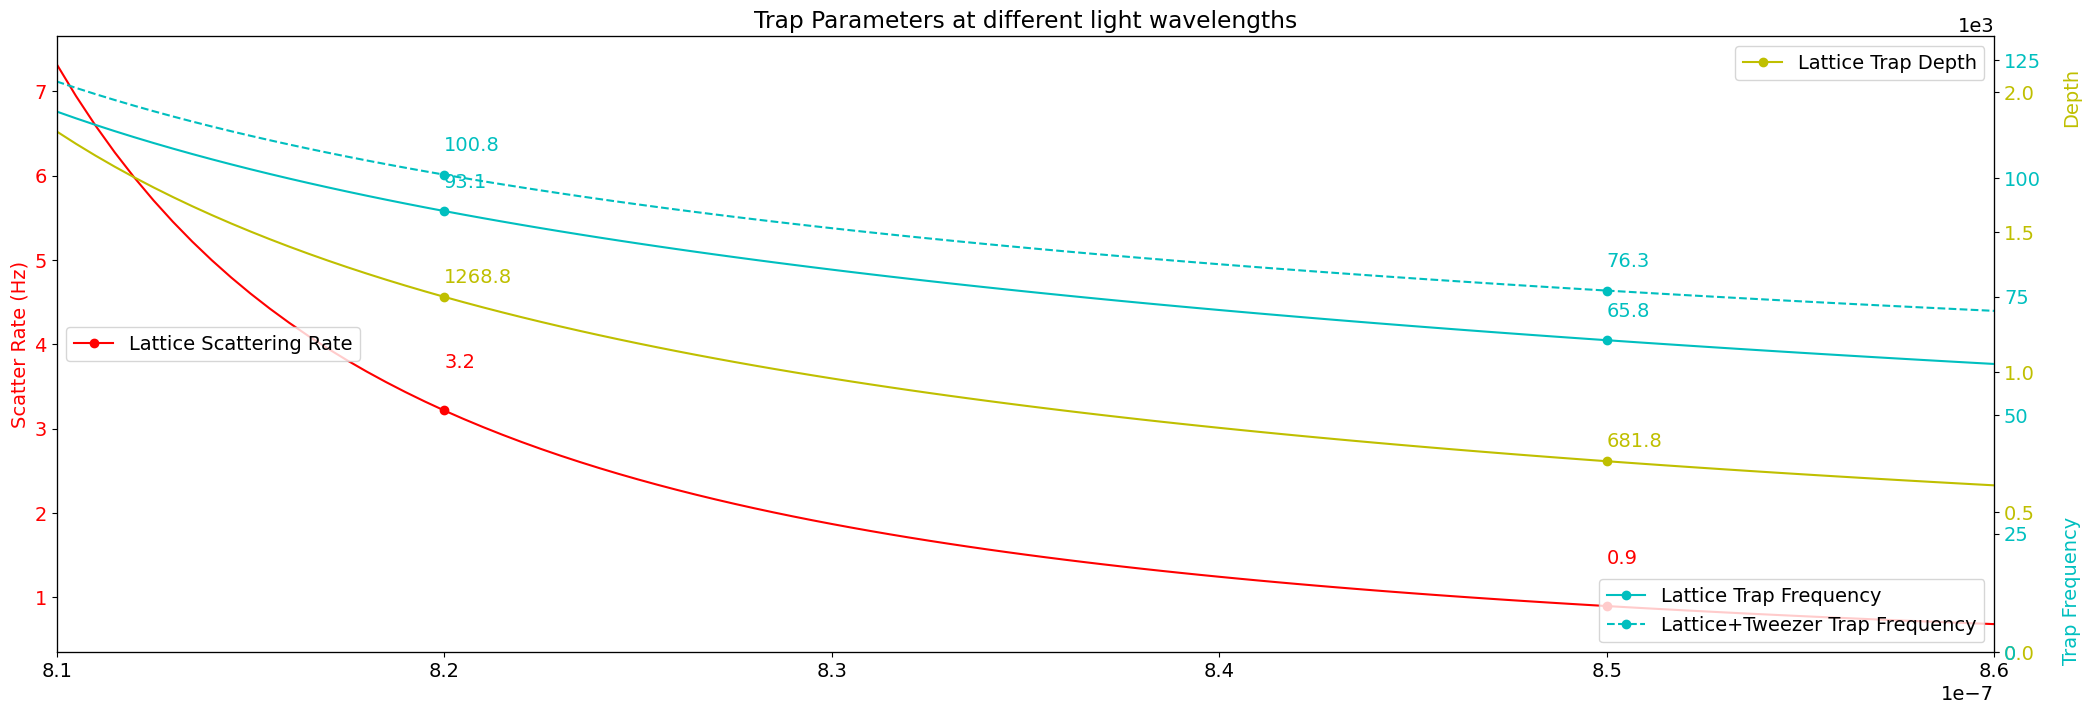

In [206]:
# in hertz
desiredTrapFrequency = 75e3
# waist is in meters
trapWaist = 170e-6
# (in meters) This is different from the wavelength because of the bowtie configuration.
powerEstimate = 1.4 * 0.8 * 0.8 * 0.9
# 
tweezerWavelength = 850*10**-9
tweezerIntensity = 3.185 * 10**11 * 0.00715
tweezerWaist = 707*10**-9
tweezerPower = tweezerIntensity * tweezerWaist**2 * np.pi/2

lightWavelengths = np.linspace(810*10**-9, 860*10**-9, 101)
latticeWavelengths = np.sqrt(2) * lightWavelengths

trapFrequencies = trapFrequency(powerEstimate, trapWaist, lightWavelengths, latticeWavelengths)
totalTrapFrequencies = latticeTweezerTrapFrequency(power, waist, tweezerWavelength, powerEstimate, trapWaist, lightWavelengths, latticeWavelengths)
depths = trapDepth(powerEstimate, trapWaist, lightWavelengths)
scatterRates = scatterRate(powerEstimate, trapWaist, lightWavelengths)
index850 = np.where(lightWavelengths==850*10**-9)[0][0]
index820 = np.where(lightWavelengths==820*10**-9)[0][0]
fig, ax1 = plt.subplots()
plt.plot(lightWavelengths, scatterRates, 'r', marker='o', markevery=[index850, index820], label='Lattice Scattering Rate')
ax1.set_ylabel('Scatter Rate (Hz)', color='r')
for tl in ax1.get_yticklabels():
    tl.set_color('r')
ax1.grid(color='r')
ax1.annotate("{:.1f}".format(scatterRates[index850]),
             xy=(lightWavelengths[index850], scatterRates[index850]+0.5), color='r')
ax1.annotate("{:.1f}".format(scatterRates[index820]),
             xy=(lightWavelengths[index820], scatterRates[index820]+0.5), color='r')
ax1.legend(loc=6)
# second plot
ax2 = ax1.twinx()
plt.plot(lightWavelengths, depths*10**-3/h, 'y', marker='o', markevery=[index850, index820], label='Lattice Trap Depth')
ax2.set_ylabel('Depth', color='y')
for tl in ax2.get_yticklabels():
    tl.set_color('y')
ax2.set_yticks(np.arange(0,2200,500))
ax2.grid(color='y')
ax2.set_ylim(0,2200)
ax2.yaxis.set_label_coords(1.035, 0.9)
ax2.annotate("{:.1f}".format(depths[index850]*10**-3/h),
             xy=(lightWavelengths[index850], depths[index850]*10**-3/h+50), color='y')
ax2.annotate("{:.1f}".format(depths[index820]*10**-3/h),
             xy=(lightWavelengths[index820], depths[index820]*10**-3/h+50), color='y')
ax2.legend(loc=1)
# third
ax3 = ax1.twinx()
plt.plot(lightWavelengths, trapFrequencies*10**-3, 'c', marker='o', markevery=[index850, index820], label='Lattice Trap Frequency')
plt.plot(lightWavelengths, totalTrapFrequencies*10**-3, 'c', linestyle='--', marker='o', markevery=[index850, index820], label='Lattice+Tweezer Trap Frequency')
ax3.set_ylabel('Trap Frequency', color='c')
for tl in ax3.get_yticklabels():
    tl.set_color('c')
ax3.set_yticks(np.arange(0,130,25))
ax3.grid(color='c')
ax3.set_ylim(0,130)
ax3.yaxis.set_label_coords(1.035, 0.1)
ax3.annotate("{:.1f}".format(trapFrequencies[index850]*10**-3),
             xy=(lightWavelengths[index850], trapFrequencies[index850]*10**-3+5), color='c')
ax3.annotate("{:.1f}".format(trapFrequencies[index820]*10**-3),
             xy=(lightWavelengths[index820], trapFrequencies[index820]*10**-3+5), color='c')
ax3.annotate("{:.1f}".format(totalTrapFrequencies[index850]*10**-3),
             xy=(lightWavelengths[index850], totalTrapFrequencies[index850]*10**-3+5), color='c')
ax3.annotate("{:.1f}".format(totalTrapFrequencies[index820]*10**-3),
             xy=(lightWavelengths[index820], totalTrapFrequencies[index820]*10**-3+5), color='c')

ax3.set_xlim(810*10**-9, 860*10**-9)
ax3.legend(loc=4)
plt.title('Trap Parameters at different light wavelengths');

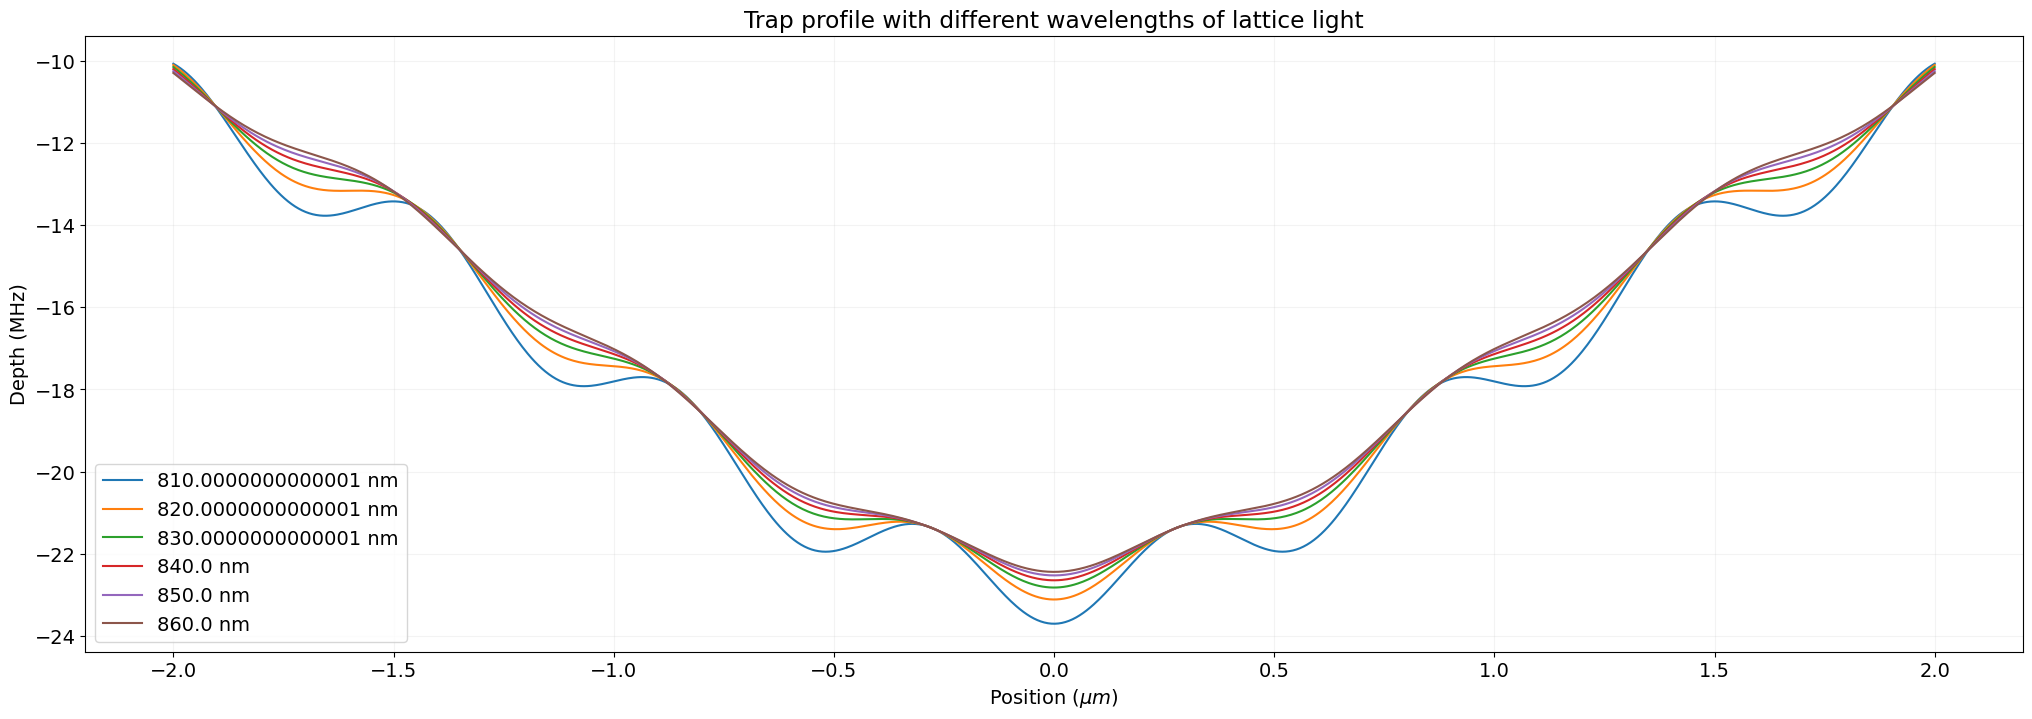

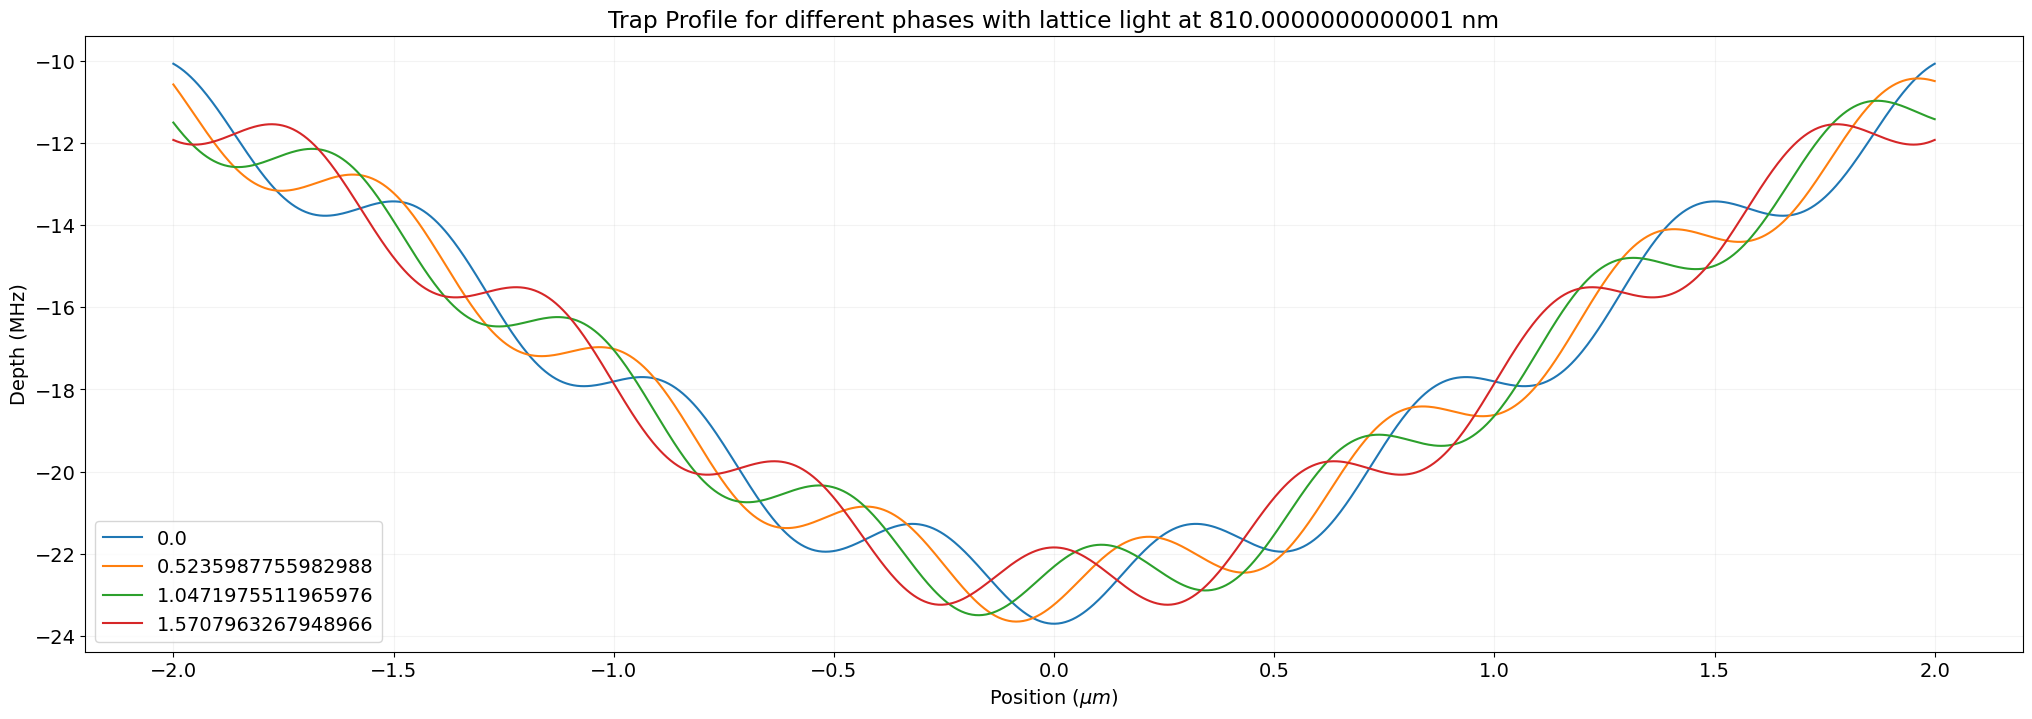

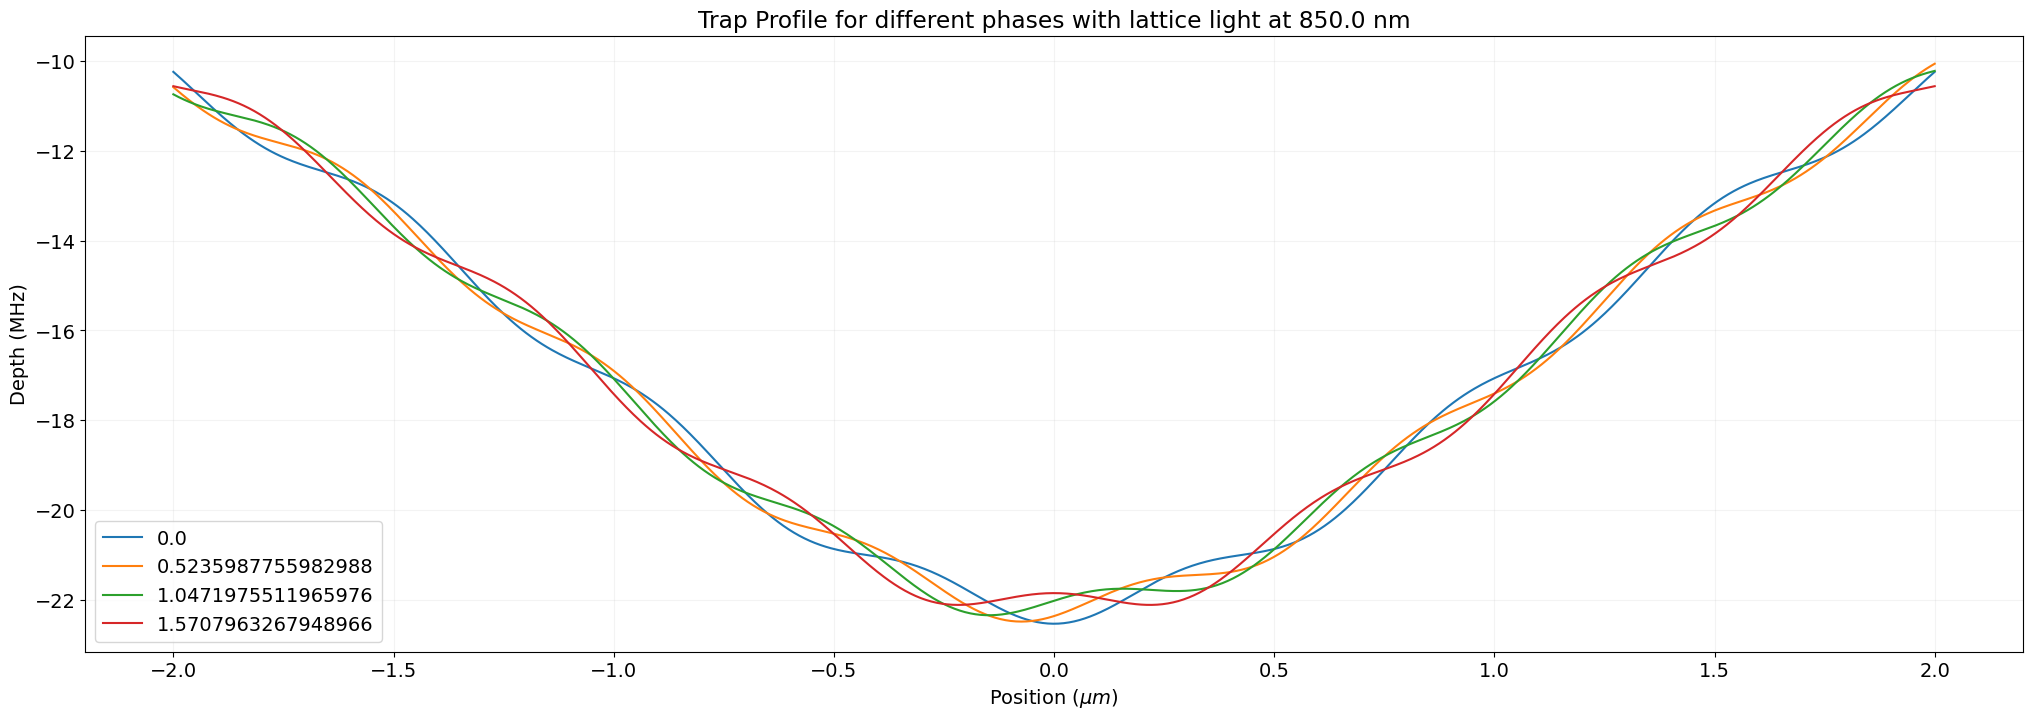

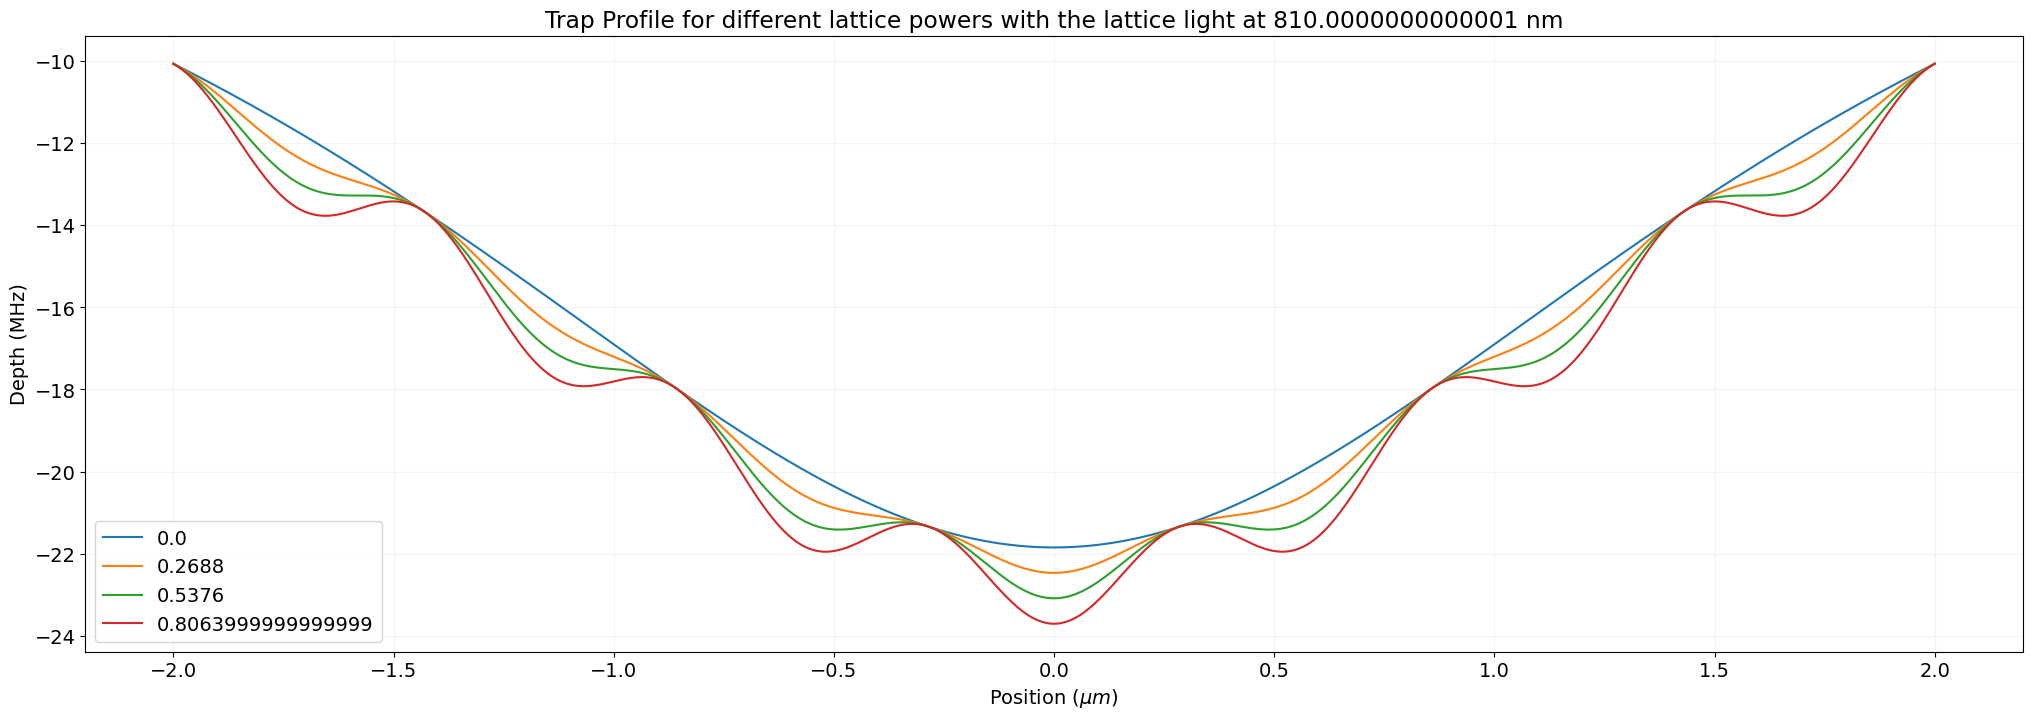

In [207]:
# (in meters) This is different from the wavelength because of the bowtie configuration.
powerEstimate = 1.4 * 0.8 * 0.8 * 0.9
# 
tweezerWavelength = 850*10**-9
tweezerIntensity = 3.185 * 10**11 * 0.00715
tweezerWaist = 707*10**-9
latticeWaist = 170*10**-6
tweezerPower = tweezerIntensity * tweezerWaist**2 * np.pi/2
positions = np.linspace(-2*10**-6, 2*10**-6, 1000)
lightWavelengths = np.linspace(810 * 10**-9, 860 * 10**-9, 6)
latticeWavelengths = np.sqrt(2) * lightWavelengths
depthProfile = np.zeros([len(lightWavelengths), len(positions)])
phases = np.linspace(0, np.pi/2, 4)

plt.figure(1)
plt.title('Trap profile with different wavelengths of lattice light')
for wavelengthInc in range(len(lightWavelengths)):
    depthProfile[wavelengthInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                          latticeWaist, lightWavelengths[wavelengthInc], 
                                                          latticeWavelengths[wavelengthInc], positions, 0)
    plt.plot(positions * 10**6, -depthProfile[wavelengthInc] / (h * 10**6), label=str(lightWavelengths[wavelengthInc]*10**9) + ' nm')
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend()

plt.figure(2)
plt.title('Trap Profile for different phases with lattice light at ' + str(lightWavelengths[0]*10**9) + ' nm')
for phaseInc in range(len(phases)):
    depthProfile[phaseInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                          latticeWaist, lightWavelengths[0], latticeWavelengths[0], positions, phases[phaseInc])
    plt.plot(positions * 10**6, -depthProfile[phaseInc] / (h * 10**6), label=str(phases[phaseInc]))
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend()

plt.figure(3)
plt.title('Trap Profile for different phases with lattice light at ' + str(lightWavelengths[-2]*10**9) + ' nm')
for phaseInc in range(len(phases)):
    depthProfile[phaseInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powerEstimate,
                                                          latticeWaist, lightWavelengths[-2], latticeWavelengths[-2], positions, phases[phaseInc])
    plt.plot(positions * 10**6, -depthProfile[phaseInc] / (h * 10**6), label=str(phases[phaseInc]))
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend();

plt.figure(4)
plt.title('Trap Profile for different lattice powers with the lattice light at ' + str(lightWavelengths[0]*10**9) + ' nm')
powers = np.linspace(0, powerEstimate, 4)
for powerInc in range(len(powers)):
    depthProfile[powerInc] = tweezerPlusLatticeDepth(tweezerPower, tweezerWaist, tweezerWavelength, powers[powerInc],
                                                     latticeWaist, lightWavelengths[0], latticeWavelengths[0], positions, 0)
    plt.plot(positions * 10**6, -depthProfile[powerInc] / (h * 10**6), label=str(powers[powerInc]))
plt.xlabel(r'Position $(\mu m)$')
plt.ylabel('Depth (MHz)')
plt.legend();

### Calculating trap depth at different NAs and powers for simple tweezers

Wednesday, April 26th, 2017, for attempting to trap a bunch of atoms.

In [208]:
na = 0.25
waist = 850e-9 / ((3.1415/2)*na)
power = 30e-3

print(waist)

#intensity = 3.185e11 * 0.00715
#waist = 707*10**-9
#power = intensity * waist**2 * np.pi/2
print(tweezerDepth(power, waist, 850*10**-9) / (6.626*10**-34 * 10**6), 'MHz')

2.1645710647779723e-06
39.11168600923893 MHz


### Calculating Scattering of tweezer light in very deep tweezer

In [209]:
scatterRate(200e-3, 0.6e-6, 850e-9) * 0.1

1784.6767209525312

# New lattice plan...

- Calculate intensity as a function of power / size parameters...
- Lattice Spacing as function of angle...
- Estimate lattice trap freq and depth...
- as a function of angle...
- think more fully about issues with depth being larger...

$$
2w_f = \frac{4\lambda}{\pi} \frac{f}{2w_0}\\
w_f = \frac{\lambda f}{\pi w_0}
$$

In [213]:
w_0_c230 = 0.452 # mm
w_0_c240 = 0.802
def get_wf(w_0):
    f_ = 0.1
    return 850e-9*f_ / (np.pi * w_0)
print('c230 size:', get_wf(w_0_c230*1e-3))
print('c240 size:', get_wf(w_0_c240*1e-3))

c230 size: 5.985916001243852e-05
c240 size: 3.3736085194042654e-05


trap freq: (Eq. c16 from "Bose-Einstein condensates in optical lattice" thesis by Henrik Andersen https://phys.au.dk/fileadmin/site_files/publikationer/phd/PhD_hka.pdf)
$$
\omega_z \approx \sqrt{\frac{2V_0}{m}}k=\sqrt{\frac{2V_0}{m}} \frac{2\pi \sin\{\theta\}}{\lambda}
$$

For perfect interference, $k = 2\pi/\lambda$. For two beams interfering at not perfect angles, I think this is $2\pi\sin\{\theta\}/\lambda$ where $\theta$ is the *half-angle* between the beams (takes maximum value at $\theta=\pi/2$)

The lenses in the exp setup are ~10cm and 2.54 cm diameter. that means

In [230]:
maxSingleLensAngle = np.arctan(2.54/2/10)
print(maxSingleLensAngle, maxSingleLensAngle*180/np.pi)

0.1263237381579653 7.237817048767123


In [70]:
maxSingleLensAngle = np.arctan(2.54/2/10)
def trapFreq1DLattice_nu(V_0, angle=maxSingleLensAngle):
    return np.sqrt(2*V_0/mc.Rb87_M) * np.sin(angle)/850e-9

In [78]:
print(trapFreq1DLattice_nu(1e-6*mc.k_B, maxSingleLensAngle/2)/1e3,"khz")
print(trapFreq1DLattice_nu(1e-6*mc.k_B, np.pi/4)/1e3,"khz")

1.0271798355946804 khz
11.507084881819068 khz


In [78]:
print(trapFreq1DLattice_nu(1e-6*mc.k_B, maxSingleLensAngle/2)/1e3,"khz")
print(trapFreq1DLattice_nu(1e-6*mc.k_B, np.pi/4)/1e3,"khz")

1.0271798355946804 khz
11.507084881819068 khz


In [231]:
11.5 * np.sqrt(60)

89.0786169627706